In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf

from patsy import dmatrices, dmatrix, build_design_matrices

import math

In [2]:
#for checking accuracy
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

In [3]:
elect_df = pd.read_csv("Obama.csv")
#Feature Engineering
obama_home_state = (elect_df['State'].fillna('No State').str.contains('HI') | elect_df['State'].fillna('No State').str.contains('IL')).astype(str)
obama_state_bad = (elect_df['State'].fillna('No State').str.contains('IA')).astype(str)
clinton_home_state = (elect_df['State'].fillna('No State').str.contains('NY')).astype(str)
clinton_home_state_1 = (elect_df['State'].fillna('No State').str.contains('AR')).astype(str)
elect_df.insert(0, 'obama_home_state', obama_home_state)
elect_df.insert(1, 'obama_state_bad', obama_state_bad)
elect_df.insert(2, 'clinton_home_state', clinton_home_state)
elect_df.insert(3, 'clinton_home_state_1', clinton_home_state_1)
#interaction variables
#elect_df['Inter_1'] = np.multiply(elect_df['Region'] != 'T.Northeast', 1) * elect_df['Bachelors']
#elect_df['Inter_2'] = np.multiply(elect_df['Region'] != 'T.South', 1) * elect_df['Black']
#elect_df['Inter_3'] = np.multiply(elect_df['Region'] != 'T.West', 1) * elect_df['Hispanic']
#Log features
elect_df['pop_log2'] = np.log2(elect_df['Pop'])
elect_df['pop_density_log2'] = np.log2(elect_df['PopDensity'])
elect_df['land_area_log2'] = np.log2(elect_df['LandArea'].fillna(1))
elect_df['farm_area_log2'] = np.log2(elect_df['FarmArea'].fillna(1))

In [4]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [5]:
#for separating trainning and testing
elect_df["ElectionDate"] = pd.to_datetime(elect_df["ElectionDate"])
elect_df_train = elect_df[elect_df["ElectionDate"] < pd.to_datetime("2/19/2008")].copy()
elect_df_test = elect_df[elect_df["ElectionDate"] >= pd.to_datetime("2/19/2008")].copy()
elect_df_train["Obama_margin"] = elect_df_train["Obama"] - elect_df_train["Clinton"]
elect_df_train["Obama_margin_percent"] = elect_df_train["Obama_margin"] / elect_df_train["TotalVote"]
elect_df_train["Obama_wins"] = elect_df_train["Obama_margin"] > 0

summarize_dataframe(elect_df)

/tmp/ipykernel_1983/2366052593.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
obama_home_state,object,0,2,2868.0,2,False,2762,,,,,,,
obama_state_bad,object,0,2,2868.0,2,False,2769,,,,,,,
clinton_home_state,object,0,2,2868.0,2,False,2806,,,,,,,
clinton_home_state_1,object,0,2,2868.0,2,False,2793,,,,,,,
County,object,0,1691,2868.0,1691,Washington,30,,,,,,,
State,object,0,46,2868.0,46,TX,251,,,,,,,
Region,object,0,4,2868.0,4,South,1419,,,,,,,
FIPS,int64,0,2868,2868.0,,,,31029.039052,1001.0,18102.5,30110.0,46123.5,56045.0,15411.398662
ElectionDate,datetime64[ns],0,18,2868.0,,,,2008-02-29 16:37:09.288702976,2008-01-03 00:00:00,2008-02-05 00:00:00,2008-02-09 00:00:00,2008-03-04 00:00:00,2008-06-03 00:00:00,
ElectionType,object,0,2,2868.0,2,Primary,2558,,,,,,,


In [6]:
#for creating database + imputer
final_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
final_imputer.fit(elect_df_train.loc[:, "MalesPer100Females":"farm_area_log2"])
elect_df_train.loc[:, "MalesPer100Females":"farm_area_log2"] = final_imputer.transform(elect_df_train.loc[:, "MalesPer100Females":"farm_area_log2"])
elect_df_test.loc[:, "MalesPer100Females":"farm_area_log2"] = final_imputer.transform(elect_df_test.loc[:, "MalesPer100Females":"farm_area_log2"])

In [7]:
#Split trainning set into smaller + imputer
elect_df_smaller_train, elect_df_validation = train_test_split(elect_df_train, test_size=.25, random_state=201)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(elect_df_smaller_train.loc[:, "MalesPer100Females":"farm_area_log2"])
elect_df_smaller_train.loc[:, "MalesPer100Females":"farm_area_log2"] = imputer.transform(elect_df_smaller_train.loc[:, "MalesPer100Females":"farm_area_log2"])
elect_df_validation.loc[:, "MalesPer100Females":"farm_area_log2"] = imputer.transform(elect_df_validation.loc[:, "MalesPer100Females":"farm_area_log2"])

In [8]:
#Lasso
variables = [variable for variable in elect_df_smaller_train.columns if variable not in ['FIPS', 'County', 'State', 'ElectionDate', 'TotalVote', 'Obama_margin', 'Obama_margin_percent', 'Obama_wins', 'Clinton', 'Obama']]
formula = 'Obama_margin_percent ~ ' + " + ".join(variables[:6]) +  " + standardize(" + ") + standardize(".join(variables[6:]) + ")"
print(formula)
y_linear, X_linear = dmatrices(formula, elect_df_smaller_train, return_type="dataframe")
# print(X_linear)
lm_lasso = Lasso(alpha = 1, max_iter=1000000)
lm_lasso.fit(X_linear, y_linear)
X_validation_linear = build_design_matrices([X_linear.design_info], elect_df_validation, return_type="dataframe")[0]
lm_lass_pred = lm_lasso.predict(X_validation_linear)
print(X_linear.columns)

Obama_margin_percent ~ obama_home_state + obama_state_bad + clinton_home_state + clinton_home_state_1 + Region + ElectionType + standardize(MalesPer100Females) + standardize(AgeBelow35) + standardize(Age35to65) + standardize(Age65andAbove) + standardize(White) + standardize(Black) + standardize(Asian) + standardize(AmericanIndian) + standardize(Hawaiian) + standardize(Hispanic) + standardize(HighSchool) + standardize(Bachelors) + standardize(Poverty) + standardize(IncomeAbove75K) + standardize(MedianIncome) + standardize(AverageIncome) + standardize(UnemployRate) + standardize(ManfEmploy) + standardize(SpeakingNonEnglish) + standardize(Medicare) + standardize(MedicareRate) + standardize(SocialSecurity) + standardize(SocialSecurityRate) + standardize(RetiredWorkers) + standardize(Disabilities) + standardize(DisabilitiesRate) + standardize(Homeowner) + standardize(SameHouse1995and2000) + standardize(Pop) + standardize(PopDensity) + standardize(LandArea) + standardize(FarmArea) + standard

In [9]:
accuracy(lm_lass_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.311966,0.254121,-8085241931389026900314719128649728.000000


In [10]:
#finding the best alphas
alphas = np.logspace(-5,0, 40)


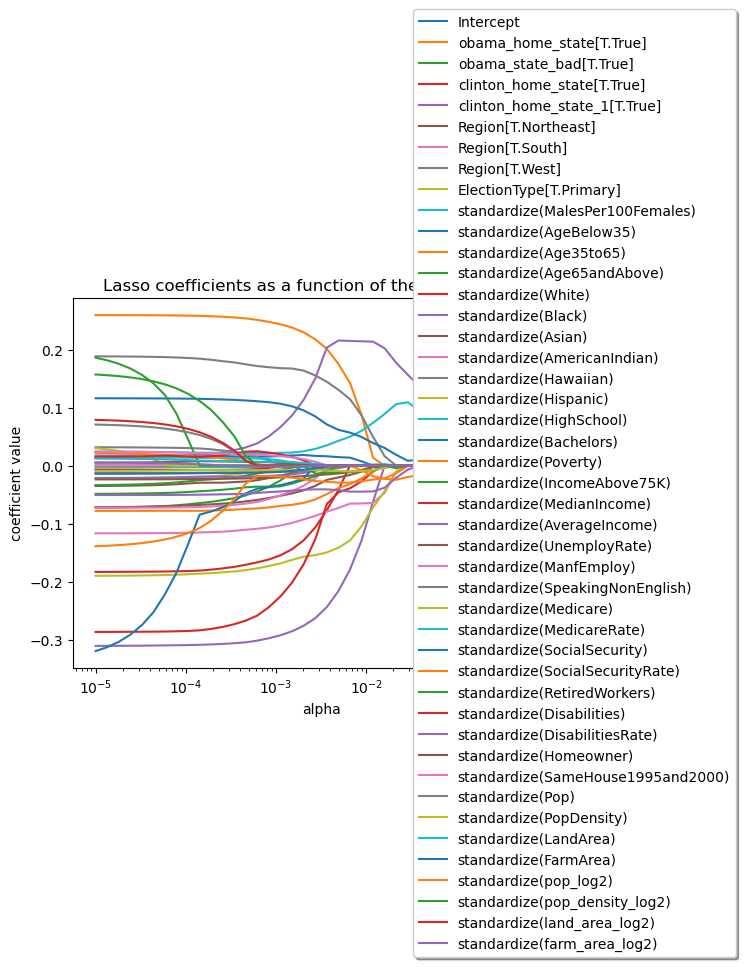

CPU times: user 2.19 s, sys: 24.5 ms, total: 2.21 s
Wall time: 2.21 s


In [11]:
%%time
coefs = []
for a in alphas:
    lm_lasso = Lasso(alpha=a, max_iter=1000000)
    lm_lasso.fit(X_linear, y_linear)
    coefs.append(lm_lasso.coef_)
    ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.show()

In [12]:
gs_lasso = GridSearchCV(Lasso(max_iter=1000000), {"alpha": alphas}, scoring='neg_mean_squared_error', cv=4)

In [13]:
%%time
gs_lasso.fit(X_linear, y_linear)
gs_lasso.best_params_['alpha']

CPU times: user 6.08 s, sys: 4.39 ms, total: 6.09 s
Wall time: 6.09 s


0.0006235507341273912

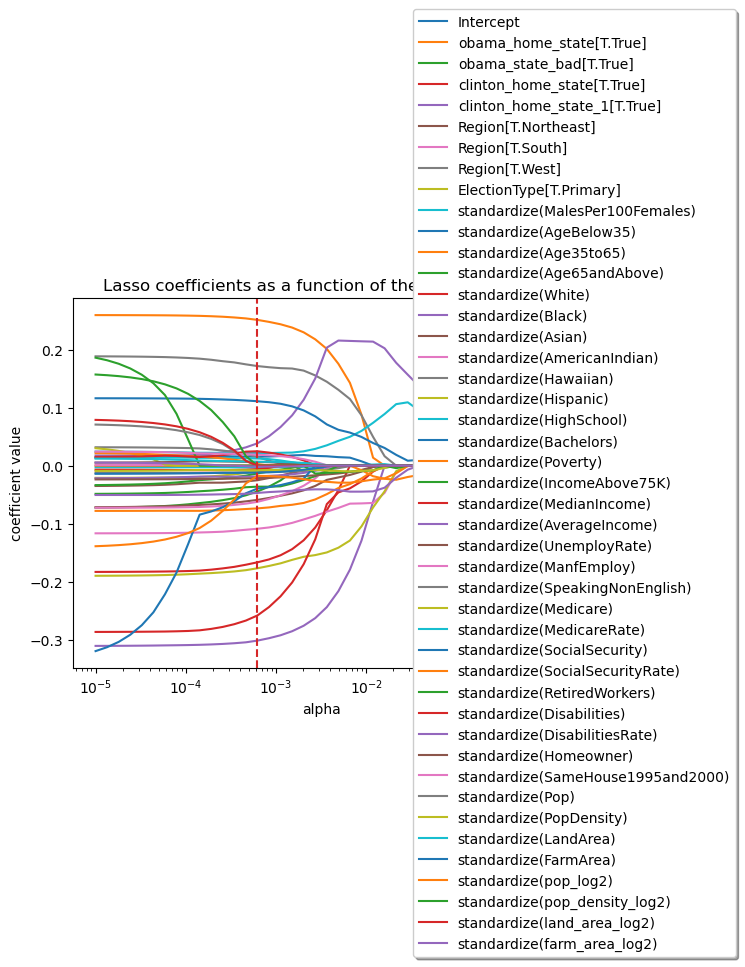

In [14]:
ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.axvline(x=gs_lasso.best_params_['alpha'], linestyle='--', color='tab:red')
plt.show()

In [15]:
lm_lasso_optimized = Lasso(alpha = gs_lasso.best_params_['alpha'], max_iter=1000000)
lm_lasso_optimized.fit(X_linear,y_linear)

Lasso(alpha=0.0006235507341273912, max_iter=1000000)

In [16]:
lm_lasso_optimized_pred = lm_lasso_optimized.predict(X_validation_linear)

In [17]:
gs_lasso_pred = gs_lasso.predict(X_validation_linear)

In [18]:
print("Accuracy of the lm_lasso_optimized model:")
accuracy(lm_lasso_optimized_pred, elect_df_validation["Obama_margin_percent"])
print("Accuracy of the gs_lasso model:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])

Accuracy of the lm_lasso_optimized model:


RMSE,MAE,R^2
0.141435,0.103792,0.736347


Accuracy of the gs_lasso model:


RMSE,MAE,R^2
0.141435,0.103792,0.736347


In [19]:
def get_linear_importances(model, data):
    # This section is to handle both LASSO and ridge.
    if len(model.coef_) == 1:
        coefficients = np.concatenate((model.coef_[0], [model.intercept_]))
    else:
        coefficients = np.concatenate((model.coef_, model.intercept_))
    coef_df = pd.DataFrame({'Importance': coefficients}, index=data.columns.append(pd.Index(["Model Intercept"])))
    return coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

In [20]:
get_linear_importances(lm_lasso_optimized, X_linear)

,Importance
clinton_home_state_1[T.True],-0.301624
standardize(White),-0.258253
obama_home_state[T.True],0.251337
ElectionType[T.Primary],-0.176896
Region[T.West],0.171721
clinton_home_state[T.True],-0.166646
Model Intercept,0.148832
standardize(Bachelors),0.111107
Region[T.South],-0.108763
standardize(Poverty),-0.073667


In [21]:
## ridge regression
alphas = np.logspace(-2,6, 40)

In [22]:
%%time
coefs = []
for a in alphas:
    lm_ridge = Ridge(alpha=a, fit_intercept=False, max_iter=1000000)
    lm_ridge.fit(X_linear, y_linear)
    coefs.append(lm_ridge.coef_[0])

CPU times: user 82 ms, sys: 0 ns, total: 82 ms
Wall time: 80.8 ms


In [23]:
gs_ridge = GridSearchCV(Ridge(fit_intercept=False, max_iter=1000000), {"alpha": alphas}, scoring='neg_mean_squared_error', cv=5)

In [24]:
%%time
gs_ridge.fit(X_linear, y_linear)

CPU times: user 749 ms, sys: 18 μs, total: 749 ms
Wall time: 748 ms


GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False, max_iter=1000000),
             param_grid={'alpha': array([1.00000000e-02, 1.60371874e-02, 2.57191381e-02, 4.12462638e-02,
       6.61474064e-02, 1.06081836e-01, 1.70125428e-01, 2.72833338e-01,
       4.37547938e-01, 7.01703829e-01, 1.12533558e+00, 1.80472177e+00,
       2.89426612e+00, 4.64158883e+00, 7.44380301e+00, 1.19377664e+01,
       1.91448198e....89652287e+01,
       1.26638017e+02, 2.03091762e+02, 3.25702066e+02, 5.22334507e+02,
       8.37677640e+02, 1.34339933e+03, 2.15443469e+03, 3.45510729e+03,
       5.54102033e+03, 8.88623816e+03, 1.42510267e+04, 2.28546386e+04,
       3.66524124e+04, 5.87801607e+04, 9.42668455e+04, 1.51177507e+05,
       2.42446202e+05, 3.88815518e+05, 6.23550734e+05, 1.00000000e+06])},
             scoring='neg_mean_squared_error')

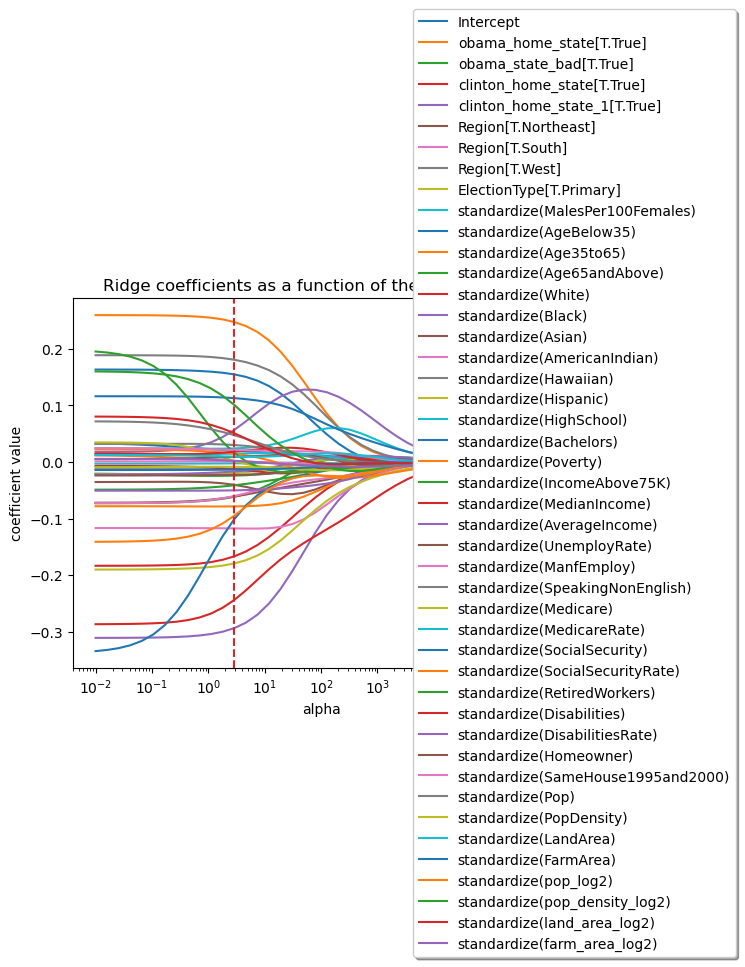

In [25]:
ax = plt.gca()


for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.axvline(x=gs_ridge.best_params_['alpha'], linestyle='--', color='tab:red')
plt.show()

In [26]:
gs_ridge_pred = gs_ridge.predict(X_validation_linear)

In [27]:
accuracy(gs_ridge_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.141960,0.104789,0.739906


In [28]:
get_linear_importances(gs_ridge.best_estimator_, X_linear)

,Importance
clinton_home_state_1[T.True],-0.293573
obama_home_state[T.True],0.247512
standardize(White),-0.243744
Region[T.West],0.180812
ElectionType[T.Primary],-0.179241
clinton_home_state[T.True],-0.166703
Intercept,0.154917
Region[T.South],-0.117339
standardize(Bachelors),0.112960
standardize(pop_density_log2),0.100939


In [29]:
print("gs_lasso accuracy:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])
print("gs_ridge accuracy:")
accuracy(gs_ridge_pred, elect_df_validation["Obama_margin_percent"])
print("ensemble accuracy:")
gs_ensemble = (gs_ridge_pred[:,0] + gs_lasso_pred) / 2
accuracy(gs_ensemble, elect_df_validation["Obama_margin_percent"])

gs_lasso accuracy:


RMSE,MAE,R^2
0.141435,0.103792,0.736347


gs_ridge accuracy:


RMSE,MAE,R^2
0.141960,0.104789,0.739906


ensemble accuracy:


RMSE,MAE,R^2
0.141531,0.104142,0.738598


In [30]:
#establish formula
variables_final = [variable for variable in elect_df_smaller_train.columns if variable not in ['FIPS', 'County', 'State', 'ElectionDate', 'TotalVote', 'Obama_margin', 'Obama_margin_percent', 'Obama_wins', 'Clinton', 'Obama']]
formula_final = 'Obama_margin_percent ~ ' + " + ".join(variables[:6]) +  " + standardize(" + ") + standardize(".join(variables[6:]) + ")"
y_linear_final, X_linear_final = dmatrices(formula_final, elect_df_train, return_type="dataframe")

In [31]:
#lasso reg
lm_lasso = Lasso(gs_lasso.best_params_['alpha'], max_iter=1000000)
lm_lasso.fit(X_linear_final, y_linear_final)
X_linear_test = build_design_matrices([X_linear_final.design_info], elect_df_test, return_type="dataframe")[0]
lasso_predictions = lm_lasso.predict(X_linear_test)


In [32]:
#ridge reg
lm_ridge = Ridge(gs_ridge.best_params_['alpha'], fit_intercept=False, max_iter=1000000)
lm_ridge.fit(X_linear_final, y_linear_final)
X_linear_test = build_design_matrices([X_linear_final.design_info], elect_df_test, return_type="dataframe")[0]
ridge_predictions = lm_ridge.predict(X_linear_test)

In [33]:
#ensemble models
bm_all_fit_pred = (lasso_predictions + ridge_predictions[:,0]) / 2
bm_all_fit_pred.shape

(1131,)

In [35]:
submission_df = pd.DataFrame(bm_all_fit_pred, index=elect_df_test.index, columns=['Obama_margin_percent'])
submission_df
submission_df.to_csv("ObamaSubmissionTeam1.csv", index_label='Row')